In [1]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

# carga y lectura de datos

In [2]:
path = "C:/Users/plane/OneDrive/Escritorio/COMPUTING SCIENCE/TFM_transformer_agents/data/SBERT_data.xlsx"
df = pd.read_excel(path)

print(len(df))
df.head()

486


,consulta usuario,respuesta positiva,respuesta negativa 1,respuesta negativa 2,respuesta negativa 3
0,¿Cual es la duración promedio de las películas...,Transforma consultas en lenguaje natural a cód...,Analiza datos de sistemas HVAC para detectar a...,Procesa documentos para extracción de texto me...,"Interactúa en conversaciones generales, respon..."
1,¿cuales son los alimentos que tengan más de 30...,Transforma consultas en lenguaje natural a cód...,Analiza datos de sistemas HVAC para detectar a...,Procesa documentos para extracción de texto me...,"Interactúa en conversaciones generales, respon..."
2,¿cuantos aviones viajaron a francia desde madr...,Transforma consultas en lenguaje natural a cód...,Analiza datos de sistemas HVAC para detectar a...,Procesa documentos para extracción de texto me...,"Interactúa en conversaciones generales, respon..."
3,Dime cómo esta organizada la base de datos,Transforma consultas en lenguaje natural a cód...,Analiza datos de sistemas HVAC para detectar a...,Procesa documentos para extracción de texto me...,"Interactúa en conversaciones generales, respon..."
4,De la base de datos 'rna central' ¿cuales son ...,Transforma consultas en lenguaje natural a cód...,Analiza datos de sistemas HVAC para detectar a...,Procesa documentos para extracción de texto me...,"Interactúa en conversaciones generales, respon..."


In [3]:
labels = df['respuesta positiva'].values
print(np.unique(labels, return_counts= True))
print('\n')
print(df['respuesta positiva'].value_counts(normalize=True))

(array(['Analiza datos de sistemas HVAC para detectar anomalías usando modelos de machine learning, preprocesa datos, realiza predicciones y entrega un informe detallado con observaciones relevantes y predicciones sobre el estado del sistema.',
       'Interactúa en conversaciones generales, respondiendo a preguntas y proporcionando información o asistencia sobre temas variados que no requieren acceso a bases de datos específicas, análisis de anomalías o procesamiento de documentos.',
       'Procesa documentos para extracción de texto mediante OCR y detecta objetos escritos a mano como firmas, iniciales, redacciones o fechas usando un modelo YOLO ajustado, y ofrece una traducción y resumen del contenido destacando información clave e indicando la ubicación del contenido manuscrito.',
       'Transforma consultas en lenguaje natural a código SQL, ejecuta consultas en la base de datos y proporciona informes detallados de los resultados en lenguaje natural.'],
      dtype=object), array(

# Preparación de datos para sentence BERT

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_data_full, test_data = train_test_split(df, random_state=42, test_size=0.10, shuffle=True, stratify=df['respuesta positiva'].values,)
train_data, val_data = train_test_split(train_data_full, random_state=42, test_size=0.15, shuffle=True, stratify=train_data_full['respuesta positiva'].values,)

print('Train and test datasets shape')
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)
print('\n')

print('Estratificiation of the data')
print(train_data['respuesta positiva'].value_counts(normalize= True).values)
print(val_data['respuesta positiva'].value_counts(normalize= True).values)
print(test_data['respuesta positiva'].value_counts(normalize= True).values)

Train and test datasets shape
(371, 5)
(66, 5)
(49, 5)


Estratificiation of the data
[0.26415094 0.26145553 0.25336927 0.22102426]
[0.25757576 0.25757576 0.25757576 0.22727273]
[0.26530612 0.26530612 0.24489796 0.2244898 ]


In [6]:
train_data.head()

,consulta usuario,respuesta positiva,respuesta negativa 1,respuesta negativa 2,respuesta negativa 3
319,¿Hay alguna mención a fechas límite o plazos e...,Procesa documentos para extracción de texto me...,Analiza datos de sistemas HVAC para detectar a...,Transforma consultas en lenguaje natural a cód...,"Interactúa en conversaciones generales, respon..."
5,¿Qué precio tienen las peliculas en las que ha...,Transforma consultas en lenguaje natural a cód...,Analiza datos de sistemas HVAC para detectar a...,Procesa documentos para extracción de texto me...,"Interactúa en conversaciones generales, respon..."
307,Detail any handwritten instructions on this re...,Procesa documentos para extracción de texto me...,Analiza datos de sistemas HVAC para detectar a...,Transforma consultas en lenguaje natural a cód...,"Interactúa en conversaciones generales, respon..."
12,Detalla el porcentaje de estudiantes que obtuv...,Transforma consultas en lenguaje natural a cód...,Analiza datos de sistemas HVAC para detectar a...,Procesa documentos para extracción de texto me...,"Interactúa en conversaciones generales, respon..."
425,Detalla cómo el cambio climático está afectand...,"Interactúa en conversaciones generales, respon...",Procesa documentos para extracción de texto me...,Analiza datos de sistemas HVAC para detectar a...,Transforma consultas en lenguaje natural a cód...


In [7]:
from sentence_transformers import InputExample
from torch.utils.data import DataLoader

In [32]:
def create_examples(df): 
    examples = []
    for i, row in df.iterrows(): 
        text = [row['consulta usuario'], row['respuesta positiva']] + row['respuesta negativa 1':'respuesta negativa 3'].tolist()
        examples.append(InputExample(texts= text))
    return examples


train_examples = create_examples(train_data_full)
val_examples = create_examples(val_data)

# Entrenamiento y validación de sentence BERT

In [33]:
from sentence_transformers import SentenceTransformer, losses, evaluation
from torch.utils.data import DataLoader
import torch

In [34]:
# Comprueba si CUDA (GPU support) está disponible
if torch.cuda.is_available():
    print("CUDA (GPU support) está disponible en este sistema.")
    print("Número de dispositivos GPU disponibles:", torch.cuda.device_count())
    print("Nombre del dispositivo GPU actual:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA (GPU support) no está disponible en este sistema.")

CUDA (GPU support) está disponible en este sistema.
Número de dispositivos GPU disponibles: 1
Nombre del dispositivo GPU actual: NVIDIA GeForce RTX 2060


In [35]:
# evaluador durante el entrenamiento para la validación
#evaluator = evaluation.EmbeddingSimilarityEvaluator(val_dataloader)
val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=16)
model_saved_path = 'C:/Users/plane/OneDrive/Escritorio/COMPUTING SCIENCE/TFM_transformer_agents/src/models/SBERT'


#max_seq_length = 256
model = SentenceTransformer('all-MiniLM-L6-v2')

train_dataloader = DataLoader(
    train_examples, shuffle=True, batch_size=16
            )

# funcion de perdida
train_loss = losses.MultipleNegativesRankingLoss(model)

# train
model.fit(
    train_objectives=[(train_dataloader, train_loss)], 
    epochs= 20, 
    warmup_steps=40, 
    optimizer_class= torch.optim.AdamW, 
    optimizer_params={'lr':2e-05},
    output_path=model_saved_path, 
    save_best_model=True, 
    show_progress_bar=True)

Epoch: 100%|██████████| 20/20 [01:44<00:00,  5.24s/it]


# Validando el modelo

In [36]:
my_model = SentenceTransformer(model_saved_path)

In [37]:
un_ejemplo = val_data['consulta usuario'].values[0]
la_resp_del_ejemplo = val_data['respuesta positiva'].values[0]
las_negativas = val_data.loc[:,'respuesta negativa 1':'respuesta negativa 3'].values[0]

print(un_ejemplo)
print(la_resp_del_ejemplo)
print(las_negativas)

Examine this workshop flyer for the date and location of the event, especially any handwritten updates.
Procesa documentos para extracción de texto mediante OCR y detecta objetos escritos a mano como firmas, iniciales, redacciones o fechas usando un modelo YOLO ajustado, y ofrece una traducción y resumen del contenido destacando información clave e indicando la ubicación del contenido manuscrito.
['Analiza datos de sistemas HVAC para detectar anomalías usando modelos de machine learning, preprocesa datos, realiza predicciones y entrega un informe detallado con observaciones relevantes y predicciones sobre el estado del sistema.'
 'Transforma consultas en lenguaje natural a código SQL, ejecuta consultas en la base de datos y proporciona informes detallados de los resultados en lenguaje natural.'
 'Interactúa en conversaciones generales, respondiendo a preguntas y proporcionando información o asistencia sobre temas variados que no requieren acceso a bases de datos específicas, análisis d

In [38]:
emb = my_model.encode(un_ejemplo)

emb_res_correcta = my_model.encode(la_resp_del_ejemplo)
emb_incorrectos = [my_model.encode(res_mala) for res_mala in las_negativas]

In [39]:
# from sklearn.metrics.pairwise import cosine_similarity
def cosine_similarity(embedding1, embedding2) -> float: 
    #print(type(embedding1), type(embedding2))
    from numpy.linalg import norm
    cos_sim = np.dot(embedding1, embedding2)/(norm(embedding1)*norm(embedding2))
    return cos_sim

print(cosine_similarity(emb, emb_res_correcta))

for vect in emb_incorrectos: 
    print(cosine_similarity(emb, vect))

0.41996613
0.028319875
-0.09343702
0.038406316


In [40]:
model = SentenceTransformer('all-MiniLM-L6-v2')
emb = model.encode(un_ejemplo)

emb_res_correcta = model.encode(la_resp_del_ejemplo)
emb_incorrectos = [model.encode(res_mala) for res_mala in las_negativas]

print(cosine_similarity(emb, emb_res_correcta))

for vect in emb_incorrectos: 
    print(cosine_similarity(emb, vect))

0.17721528
0.091546685
0.0036100738
0.13311857


In [45]:
def prepare_test(df, model): 
    examples = []
    for i, row in df.iterrows(): 
        text_and_embeddings = {
                row['consulta usuario']: model.encode(row['consulta usuario']), 
                row['respuesta positiva']:model.encode(row['respuesta positiva']), 
                row['respuesta negativa 1']:model.encode(row['respuesta negativa 1']), 
                row['respuesta negativa 2']:model.encode(row['respuesta negativa 2']),
                row['respuesta negativa 3']:model.encode(row['respuesta negativa 3'])}
        examples.append(pd.Series(text_and_embeddings))
    return examples


val_examples_embeddings = prepare_test(val_data, model= my_model)
# test_exam_not_trained_model = prepare_test(test_data, model= model)
#print(test_examples_embeddings[:2])
#test_data.head()

In [46]:
print(val_examples_embeddings[0].index)
#print(test_examples_embeddings[10].index[3])

Index(['Examine this workshop flyer for the date and location of the event, especially any handwritten updates.',
       'Procesa documentos para extracción de texto mediante OCR y detecta objetos escritos a mano como firmas, iniciales, redacciones o fechas usando un modelo YOLO ajustado, y ofrece una traducción y resumen del contenido destacando información clave e indicando la ubicación del contenido manuscrito.',
       'Analiza datos de sistemas HVAC para detectar anomalías usando modelos de machine learning, preprocesa datos, realiza predicciones y entrega un informe detallado con observaciones relevantes y predicciones sobre el estado del sistema.',
       'Transforma consultas en lenguaje natural a código SQL, ejecuta consultas en la base de datos y proporciona informes detallados de los resultados en lenguaje natural.',
       'Interactúa en conversaciones generales, respondiendo a preguntas y proporcionando información o asistencia sobre temas variados que no requieren acceso 

In [47]:
print(cosine_similarity(val_examples_embeddings[0][0], val_examples_embeddings[0][1]))
print(cosine_similarity(val_examples_embeddings[0][0], val_examples_embeddings[0][2]))
print(cosine_similarity(val_examples_embeddings[0][0], val_examples_embeddings[0][3]))
print(cosine_similarity(val_examples_embeddings[0][0], val_examples_embeddings[0][4]))

0.41996613
0.028319875
-0.09343702
0.038406316


In [49]:
def parse_labels(data):
    parsed_labels = []
    for n in data: 
        #print(n)
        if n == 'Analiza datos de sistemas HVAC para detectar anomalías usando modelos de machine learning, preprocesa datos, realiza predicciones y entrega un informe detallado con observaciones relevantes y predicciones sobre el estado del sistema.': 
            parsed_labels.append('HVAC')
        elif n == 'Interactúa en conversaciones generales, respondiendo a preguntas y proporcionando información o asistencia sobre temas variados que no requieren acceso a bases de datos específicas, análisis de anomalías o procesamiento de documentos.': 
            parsed_labels.append('CHAT')
        elif n == 'Procesa documentos para extracción de texto mediante OCR y detecta objetos escritos a mano como firmas, iniciales, redacciones o fechas usando un modelo YOLO ajustado, y ofrece una traducción y resumen del contenido destacando información clave e indicando la ubicación del contenido manuscrito.': 
            parsed_labels.append('OCR')
        elif n == 'Transforma consultas en lenguaje natural a código SQL, ejecuta consultas en la base de datos y proporciona informes detallados de los resultados en lenguaje natural.': 
            parsed_labels.append('SQL')
    return parsed_labels

val_ground_truth = parse_labels(val_data['respuesta positiva'])
print(val_ground_truth)

['OCR', 'OCR', 'CHAT', 'HVAC', 'SQL', 'OCR', 'CHAT', 'SQL', 'SQL', 'SQL', 'HVAC', 'OCR', 'OCR', 'HVAC', 'SQL', 'CHAT', 'SQL', 'HVAC', 'HVAC', 'SQL', 'CHAT', 'HVAC', 'HVAC', 'OCR', 'SQL', 'CHAT', 'OCR', 'OCR', 'OCR', 'CHAT', 'CHAT', 'OCR', 'HVAC', 'HVAC', 'SQL', 'OCR', 'SQL', 'CHAT', 'CHAT', 'SQL', 'OCR', 'HVAC', 'CHAT', 'OCR', 'HVAC', 'OCR', 'OCR', 'CHAT', 'HVAC', 'OCR', 'SQL', 'HVAC', 'HVAC', 'SQL', 'CHAT', 'OCR', 'CHAT', 'CHAT', 'HVAC', 'CHAT', 'CHAT', 'SQL', 'SQL', 'SQL', 'SQL', 'CHAT']


In [50]:
predicted_text = []
#max_similarities = []
for example in val_examples_embeddings: 

    emb_consulta = example[0]
    similaritys = [cosine_similarity(emb_consulta, emb_respuesta) for emb_respuesta in example[1:]]
    predicted_index = 1 + np.argmax(similaritys)
    predicted_text.append(example.index[predicted_index])

val_predicted_labels = parse_labels(predicted_text)
print(val_predicted_labels)

['OCR', 'OCR', 'CHAT', 'HVAC', 'SQL', 'OCR', 'CHAT', 'SQL', 'SQL', 'SQL', 'HVAC', 'OCR', 'OCR', 'HVAC', 'SQL', 'CHAT', 'SQL', 'HVAC', 'HVAC', 'SQL', 'CHAT', 'HVAC', 'HVAC', 'OCR', 'SQL', 'CHAT', 'OCR', 'OCR', 'OCR', 'CHAT', 'CHAT', 'OCR', 'HVAC', 'HVAC', 'SQL', 'OCR', 'SQL', 'CHAT', 'CHAT', 'SQL', 'OCR', 'HVAC', 'CHAT', 'OCR', 'HVAC', 'OCR', 'OCR', 'CHAT', 'HVAC', 'OCR', 'SQL', 'HVAC', 'HVAC', 'SQL', 'CHAT', 'OCR', 'CHAT', 'CHAT', 'HVAC', 'CHAT', 'CHAT', 'SQL', 'SQL', 'SQL', 'SQL', 'CHAT']


In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix


print(accuracy_score(y_true= val_ground_truth, y_pred= val_predicted_labels))

conf_matrix = confusion_matrix(y_true= val_ground_truth, y_pred= val_predicted_labels)

print(conf_matrix)

1.0
[[17  0  0  0]
 [ 0 15  0  0]
 [ 0  0 17  0]
 [ 0  0  0 17]]


# Fase de test

## modelo sin entrenar

In [55]:
labels = ['SQL', 'OCR', 'HVAC', 'CHAT']

In [85]:
test_examples_embeddings = prepare_test(test_data, model= model)

test_ground_truth = parse_labels(test_data['respuesta positiva'])

predicted_text = []
max_similarities_not_ft = []
for example in test_examples_embeddings: 

    emb_consulta = example[0]
    similaritys = [cosine_similarity(emb_consulta, emb_respuesta) for emb_respuesta in example[1:]]
    predicted_index = 1 + np.argmax(similaritys)
    max_similarities_not_ft.append(max(similaritys))
    predicted_text.append(example.index[predicted_index])
test_predicted_labels = parse_labels(predicted_text)
#print(test_predicted_labels)

print('Accuracy of the not fine tuned model')
print(accuracy_score(y_true= test_ground_truth, y_pred= test_predicted_labels))

conf_matrix_no_train_model = confusion_matrix(y_true= test_ground_truth, y_pred= test_predicted_labels, labels = labels)

print('The confusion matrix of the NOT fine tuned model')
print(conf_matrix_no_train_model)

Accuracy of the not fine tuned model
0.7142857142857143
The confusion matrix of the NOT fine tuned model
[[ 7  1  1  3]
 [ 2  8  0  3]
 [ 0  0 10  1]
 [ 0  1  2 10]]


## modelo entrenado

In [82]:
test_examples_embeddings = prepare_test(test_data, model= my_model)

predicted_text = []
max_similarities_ft = []
for example in test_examples_embeddings: 

    emb_consulta = example[0]
    similaritys = [cosine_similarity(emb_consulta, emb_respuesta) for emb_respuesta in example[1:]]
    predicted_index = 1 + np.argmax(similaritys)
    max_similarities_ft.append(max(similaritys))
    predicted_text.append(example.index[predicted_index])
test_predicted_labels = parse_labels(predicted_text)
#print(test_predicted_labels)

print('Accuracy of the fine tuned model')
print(accuracy_score(y_true= test_ground_truth, y_pred= test_predicted_labels))

conf_matrix_trained_model = confusion_matrix(y_true= test_ground_truth, y_pred= test_predicted_labels, labels = labels)

print('The confusion matrix of the fine tuned model')
print(conf_matrix_trained_model)

Accuracy of the fine tuned model
1.0
The confusion matrix of the fine tuned model
[[12  0  0  0]
 [ 0 13  0  0]
 [ 0  0 11  0]
 [ 0  0  0 13]]


In [83]:
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import colormaps
#list(colormaps)

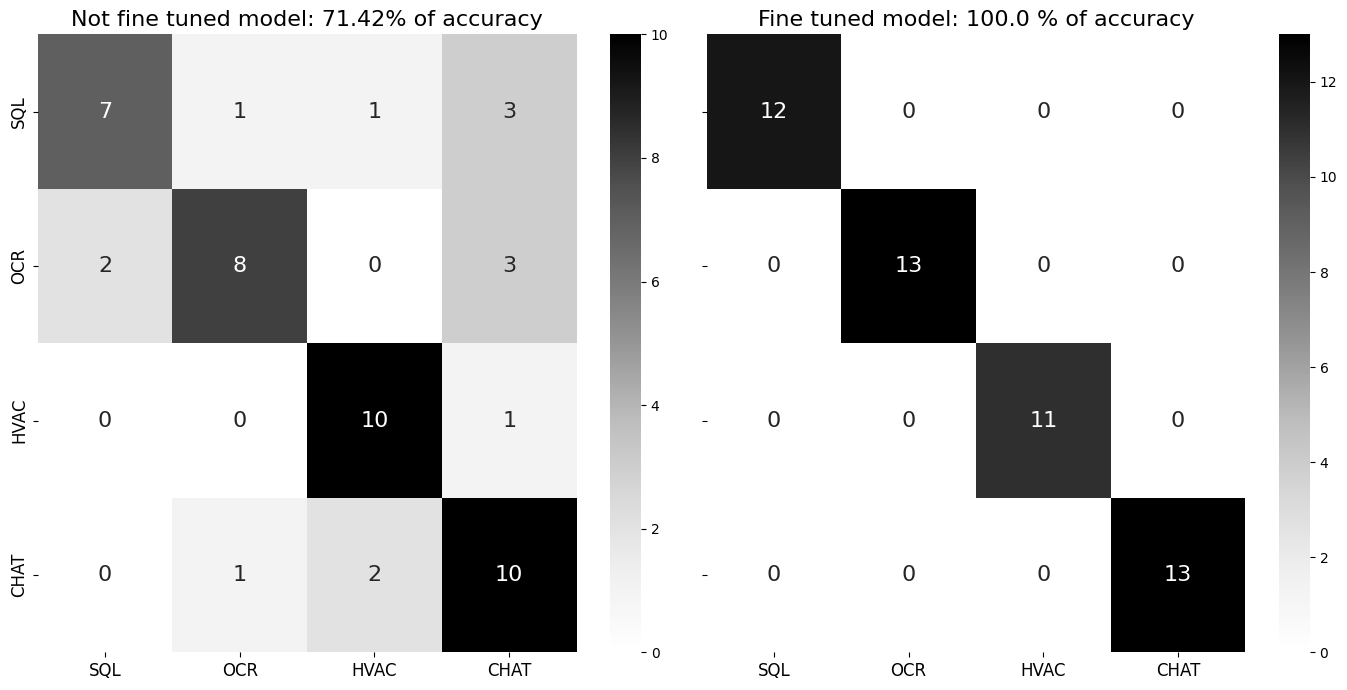

In [119]:
import matplotlib.pyplot as plt 
import seaborn as sns

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize= (14, 7))

sns.heatmap(
    conf_matrix_no_train_model, 
    annot= True, 
    fmt= 'd', 
    cmap='Greys', 
    xticklabels=labels, 
    yticklabels=labels, 
    annot_kws={"size": 16}, 
    cbar=True, ax=ax1)
ax1.set_title(f'Not fine tuned model: {71.42}% of accuracy', fontsize= 16)
ax1.set_xticklabels(labels, fontsize=12)
ax1.set_yticklabels(labels, fontsize=12)

sns.heatmap(
    conf_matrix_trained_model, 
    annot= True, 
    fmt= 'd', 
    cmap='Greys', 
    xticklabels=labels, 
    yticklabels=labels, 
    annot_kws={"size": 16}, 
    cbar=True, ax=ax2)

ax2.set_title(f'Fine tuned model: {100.00} % of accuracy', fontsize= 16)
ax2.set_xticklabels(labels, fontsize=12)
ax2.set_yticklabels(labels, fontsize=12)

plt.savefig('FT_LM_conf_matrix.png', bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

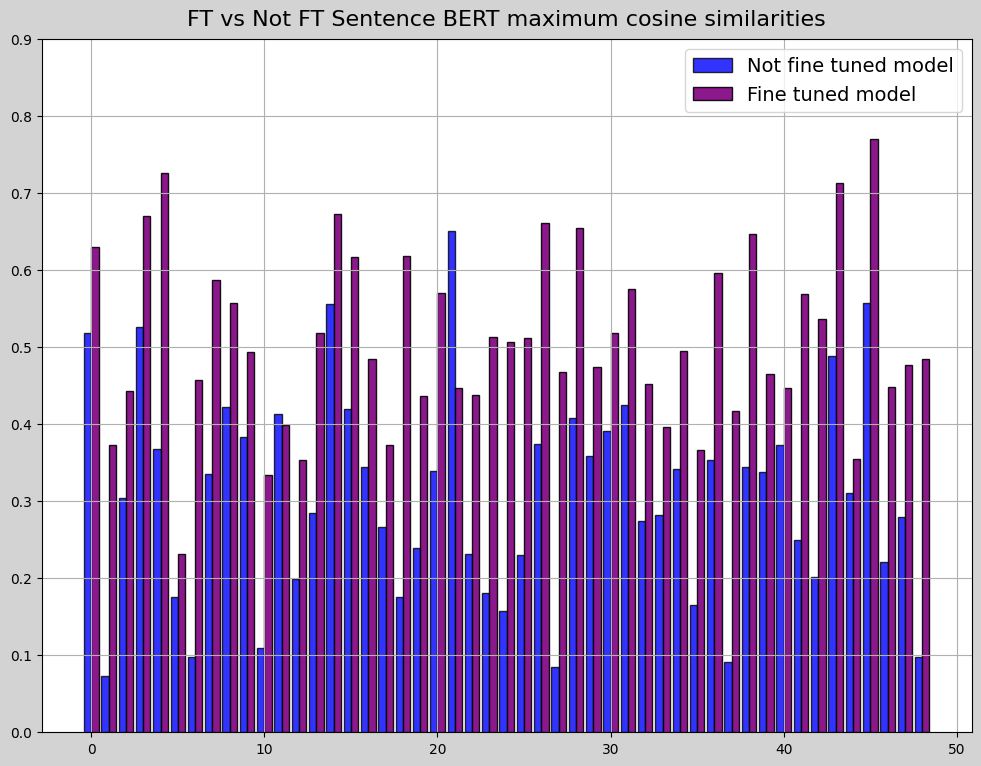

In [120]:
x = np.arange(len(test_data))
ancho = 0.42

plt.figure(figsize=(12, 9), facecolor='lightgrey')

plt.bar(x= x - ancho/2, height= max_similarities_not_ft, width=ancho,color='blue', alpha= 0.8, label= 'Not fine tuned model', edgecolor='black')
plt.bar(x= x + ancho/2, height=max_similarities_ft, width=ancho, color= 'purple', alpha= 0.9, label= 'Fine tuned model', edgecolor='black')
plt.legend(fontsize= 14)
plt.grid()
plt.ylim(top= 0.9)
plt.title('FT vs Not FT Sentence BERT maximum cosine similarities', fontsize= 16, pad=10)

plt.savefig('max_cosine_similarities.png', bbox_inches='tight', dpi=300, facecolor='lightgrey')
plt.show()